# Modeling

In [36]:
from sklearn import metrics
import catboost as cat
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error as mae, r2_score as r2
from scipy.stats import uniform, randint

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

def mae(y_gt, Y_pr):
    return metrics.mean_absolute_error(y_gt, Y_pr)

def mse(y_gt, Y_pr):
    return metrics.mean_squared_error(y_gt, Y_pr)

def rmse(y_gt, Y_pr):
    my_mse = mse(y_gt, Y_pr)
    return np.sqrt(my_mse)

def medae(y_gt, Y_pr):
    return metrics.median_absolute_error(y_gt, Y_pr)

def R2(y_gt, Y_pr):
    return metrics.r2_score(y_gt, Y_pr)

def calc_metrics(y_test, y_pred, X):
    
    y_test = target_transformer.inverse_transform(y_test)
    y_pred = target_transformer.inverse_transform(pd.Series(y_pred))

    mse1 = mse(y_test, y_pred)

    rmse1 = rmse(y_test, y_pred)

    mae1 = mae(y_test, y_pred)

    medae1 = medae(y_test, y_pred)

    R21 = R2(y_test, y_pred)
    
    adj_r2 = 1 - (1-r2(y_test, y_pred)) * (len(y)-1)/(len(y)-X.shape[1]-1)

    print('*** VAL **: ')
    print("MSE:   {}\nRMSE:  {}\nR2:    {}\nMAE:   {}\nMedAE: {}\nAdj_R2:  {}".format(mse1, rmse1, R21, mae1, medae1, adj_r2))
    print('-'*30)


def get_importance(train_dataset, cat_model, title='Catboost feature importance', save_fig=False, file_name='cat_feature_importance.png'):
    imp = cat_model.get_feature_importance(data=train_dataset)
    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    axes.barh(width=imp, y=cat_model.feature_names_)
    axes.set_title(title)
    if save_fig:
        plt.savefig(file_name)
    plt.show()
    

def draw_target_distr(y_test, y_pred, save_fig=False, file_name='cat_distribution'):
    plt.figure(figsize=(12, 5))
    sns.distplot(y_test)
    sns.distplot(y_pred)
    plt.legend(['test', 'pred'])
    if save_fig:
        plt.savefig(file_name)
    plt.show()

    
def draw_residuals(y_test, y_pred, save_fig=False,
                   file_name='cat_residuals.png'):
    y_test = target_transformer.inverse_transform(y_test)
    y_pred = target_transformer.inverse_transform(pd.Series(y_pred))  / MULTIPLIER
    sns.residplot(x=y_test, y=y_pred)
    if save_fig:
        plt.savefig(file_name)
    plt.show()
    
class TargetTransformer:
    def __init__(self, denominator=1):
        self.scale = denominator
        
    def inverse_transform(self, feature):
        return feature.apply(lambda x: np.expm1(x))
    
    def transform(self, feature):
        return feature.apply(lambda x: np.log1p(x))

In [37]:
with open('./dataset_0.pkl', 'rb') as f:
    df_pr = pickle.load(f)

In [38]:
df_pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9483 entries, 0 to 9482
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age_access_type    9483 non-null   int64  
 1   average_rating     8958 non-null   float64
 2   duration           9483 non-null   float64
 3   type               9483 non-null   object 
 4   name               9483 non-null   object 
 5   release_year       9483 non-null   object 
 6   target             9483 non-null   float64
 7   subscription_only  9483 non-null   object 
 8   actor_0            9483 non-null   object 
 9   actor_1            9483 non-null   object 
 10  actor_2            9483 non-null   object 
 11  actor_3            9483 non-null   object 
 12  actor_4            9483 non-null   object 
 13  country_0          9483 non-null   object 
 14  genre_0            9483 non-null   object 
 15  genre_1            9483 non-null   object 
 16  genre_2            9483 

# 2

In [39]:
cat_features = ['type', 'subscription_only', 'actor_0', 'actor_1',
               'actor_2', 'actor_3', 'actor_4', 'country_0', 'genre_0', 'genre_1',
               'genre_2', 'director_0', 'SUBSCRIPTION', 'AVOD', 'DTO', 'RENT']
num_features = ['age_access_type', 'average_rating', 'duration']

target_transformer = TargetTransformer()

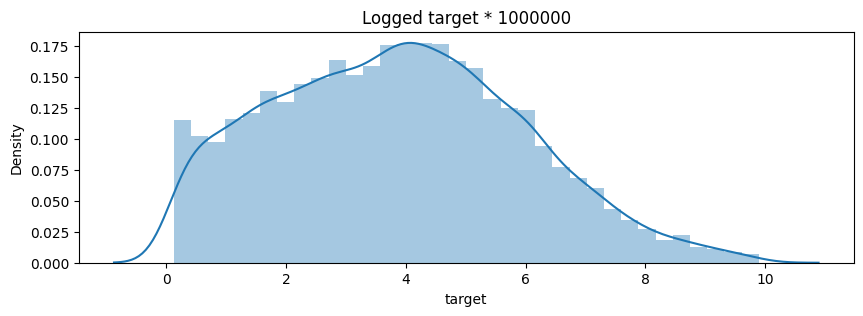

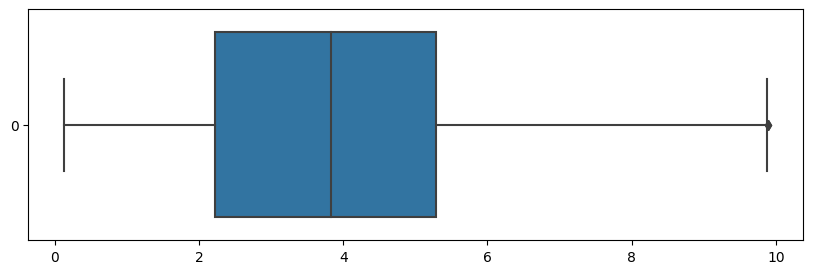

In [49]:
MULTIPLIER = 1000000
X, y = df_pr.drop(['target', 'name', 'release_year'], axis=1), df_pr['target'] * MULTIPLIER
y = target_transformer.transform(y)


plt.figure(figsize=(10, 3))
sns.distplot(y)
plt.title(f'Logged target * {MULTIPLIER}')
plt.show()

plt.figure(figsize=(10, 3))
sns.boxplot(y, orient='h')
plt.show()

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42, shuffle=True)
train_dataset = cat.Pool(X_train, y_train,
                         cat_features=cat_features,   
                        ) 
test_dataset = cat.Pool(X_test, y_test,
                         cat_features=cat_features,
                       )
val_dataset = cat.Pool(X_val, y_val,
                       cat_features=cat_features,
                      )

In [51]:
cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features,
    'iterations': 10000, 
}

cat_model = cat.CatBoostRegressor(**cat_params)

cat_model.fit(
    train_dataset,
    eval_set=val_dataset,
    early_stopping_rounds=50,
    verbose=100,
    plot=False
)

Learning rate set to 0.017502
0:	learn: 1.7003589	test: 1.6888486	best: 1.6888486 (0)	total: 12.6ms	remaining: 2m 5s
100:	learn: 1.5381708	test: 1.5231673	best: 1.5231673 (100)	total: 1.06s	remaining: 1m 43s
200:	learn: 1.4788594	test: 1.4686190	best: 1.4686190 (200)	total: 2.11s	remaining: 1m 43s
300:	learn: 1.4480677	test: 1.4468513	best: 1.4466202 (298)	total: 3.17s	remaining: 1m 42s
400:	learn: 1.4244280	test: 1.4311445	best: 1.4311445 (400)	total: 4.22s	remaining: 1m 40s
500:	learn: 1.4059759	test: 1.4183722	best: 1.4182168 (494)	total: 5.25s	remaining: 1m 39s
600:	learn: 1.3861677	test: 1.4093714	best: 1.4093714 (600)	total: 6.3s	remaining: 1m 38s
700:	learn: 1.3694271	test: 1.3982612	best: 1.3981377 (697)	total: 7.36s	remaining: 1m 37s
800:	learn: 1.3568813	test: 1.3890942	best: 1.3890942 (800)	total: 8.4s	remaining: 1m 36s
900:	learn: 1.3452584	test: 1.3838944	best: 1.3835864 (887)	total: 9.46s	remaining: 1m 35s
1000:	learn: 1.3338227	test: 1.3768758	best: 1.3768597 (999)	total

In [59]:
cat_model.save_model('2')

In [60]:
y_pred = cat_model.predict(X_test)

In [61]:
calc_metrics(y_test, y_pred, X)

*** VAL **: 
MSE:   1859117.4423789755
RMSE:  1363.494569985145
R2:    0.023711450390574873
MAE:   353.8244251297264
MedAE: 48.19636635511948
Adj_R2:  0.02175123878298968
------------------------------


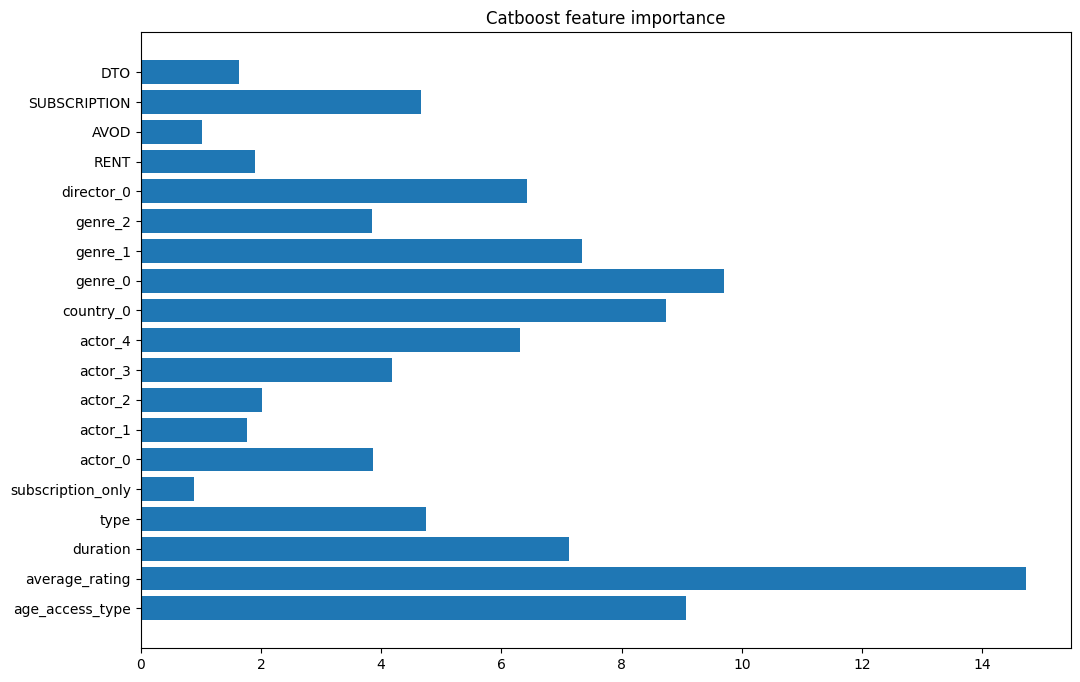

In [62]:
get_importance(train_dataset, cat_model, title='Catboost feature importance', save_fig=False, file_name='cat_feature_importance.png')

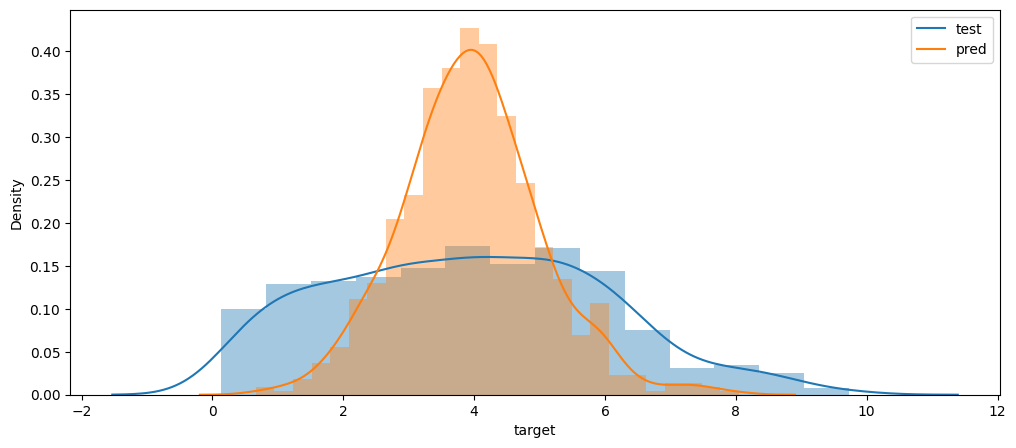

In [56]:
draw_target_distr(y_test, y_pred, save_fig=False, file_name='cat_distribution')

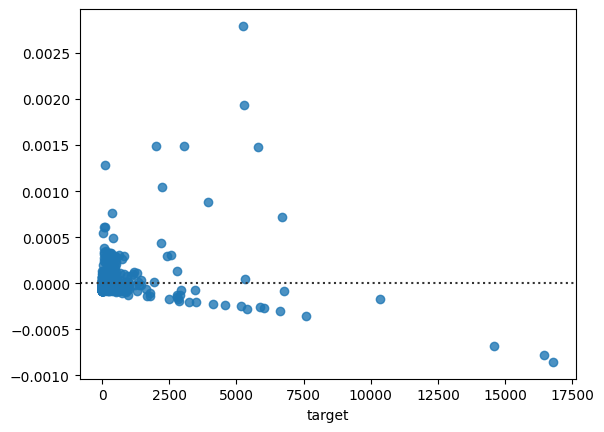

In [57]:
draw_residuals(y_test, y_pred, save_fig=False)

In [58]:
len(y_pred[y_pred <= 0])

0

## 2_1 keep release_year

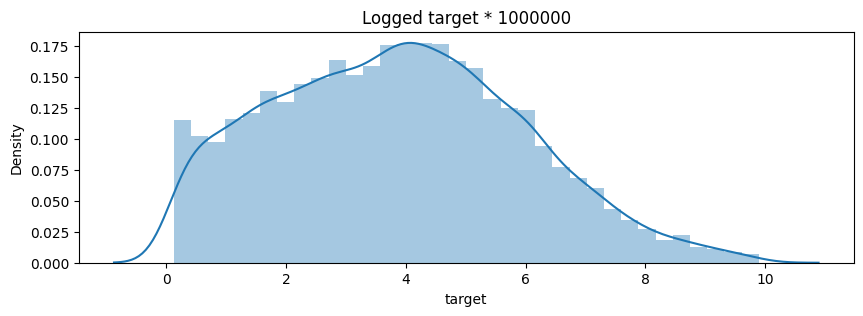

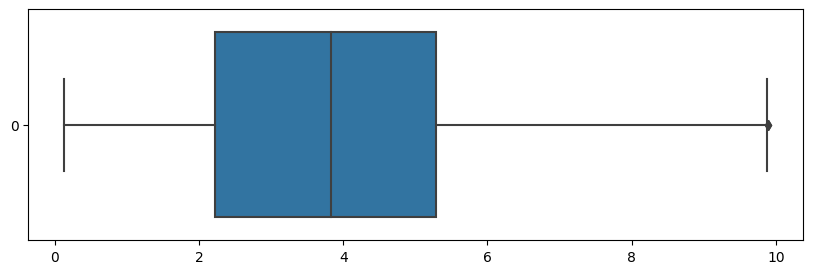

In [63]:
MULTIPLIER = 1000000
X, y = df_pr.drop(['target', 'name'], axis=1), df_pr['target'] * MULTIPLIER
y = target_transformer.transform(y)


plt.figure(figsize=(10, 3))
sns.distplot(y)
plt.title(f'Logged target * {MULTIPLIER}')
plt.show()

plt.figure(figsize=(10, 3))
sns.boxplot(y, orient='h')
plt.show()

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42, shuffle=True)
train_dataset = cat.Pool(X_train, y_train,
                         cat_features=cat_features,   
                        ) 
test_dataset = cat.Pool(X_test, y_test,
                         cat_features=cat_features,
                       )
val_dataset = cat.Pool(X_val, y_val,
                       cat_features=cat_features,
                      )

In [65]:
cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features,
    'iterations': 10000, 
}

cat_model = cat.CatBoostRegressor(**cat_params)

cat_model.fit(
    train_dataset,
    eval_set=val_dataset,
    early_stopping_rounds=50,
    verbose=100,
    plot=False
)

Learning rate set to 0.017502
0:	learn: 1.6959281	test: 1.6847836	best: 1.6847836 (0)	total: 13.7ms	remaining: 2m 17s
100:	learn: 1.3571782	test: 1.3017179	best: 1.3017179 (100)	total: 1.05s	remaining: 1m 43s
200:	learn: 1.2656768	test: 1.2231411	best: 1.2231411 (200)	total: 2.12s	remaining: 1m 43s
300:	learn: 1.2259894	test: 1.1912938	best: 1.1912938 (300)	total: 3.16s	remaining: 1m 41s
400:	learn: 1.2006605	test: 1.1710895	best: 1.1710895 (400)	total: 4.21s	remaining: 1m 40s
500:	learn: 1.1808693	test: 1.1498489	best: 1.1498489 (500)	total: 5.26s	remaining: 1m 39s
600:	learn: 1.1633179	test: 1.1346001	best: 1.1346001 (600)	total: 6.32s	remaining: 1m 38s
700:	learn: 1.1469158	test: 1.1218421	best: 1.1218421 (700)	total: 7.34s	remaining: 1m 37s
800:	learn: 1.1319831	test: 1.1122025	best: 1.1121998 (799)	total: 8.4s	remaining: 1m 36s
900:	learn: 1.1209801	test: 1.1062803	best: 1.1062803 (900)	total: 9.46s	remaining: 1m 35s
1000:	learn: 1.1106419	test: 1.0996111	best: 1.0996111 (1000)	to

In [66]:
cat_model.save_model('2_1')

In [67]:
y_pred = cat_model.predict(X_test)

In [68]:
calc_metrics(y_test, y_pred, X)

*** VAL **: 
MSE:   1532582.5043311603
RMSE:  1237.975163051004
R2:    0.19518653517896234
MAE:   316.9297014958452
MedAE: 34.16642934088895
Adj_R2:  0.1934853864475714
------------------------------


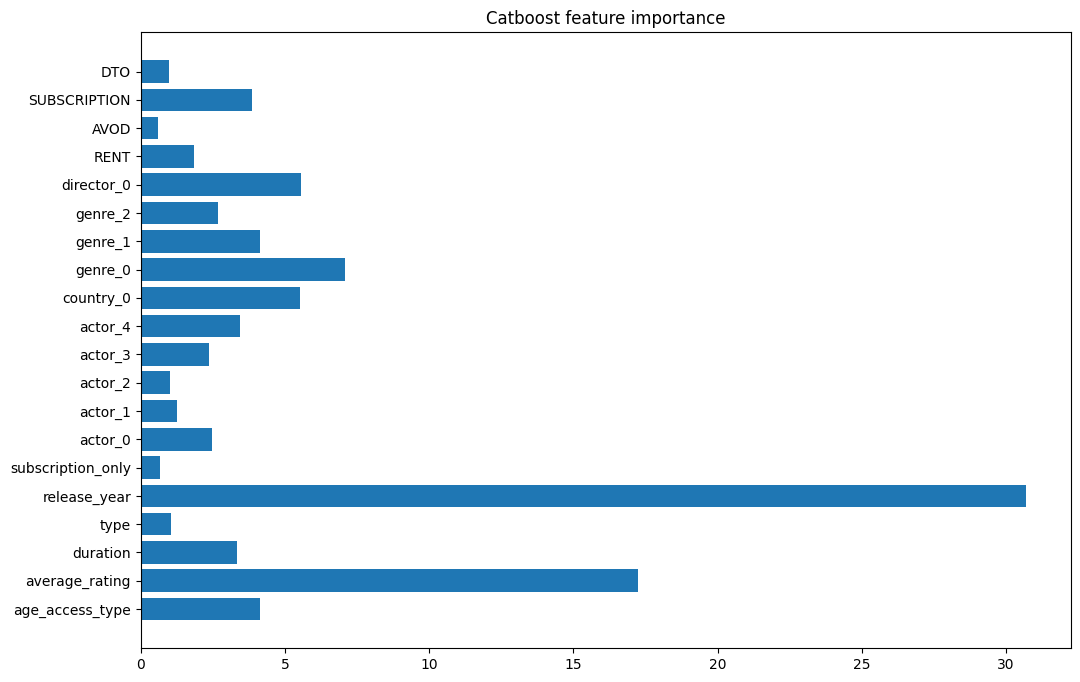

In [69]:
get_importance(train_dataset, cat_model, title='Catboost feature importance', save_fig=False, file_name='cat_feature_importance.png')

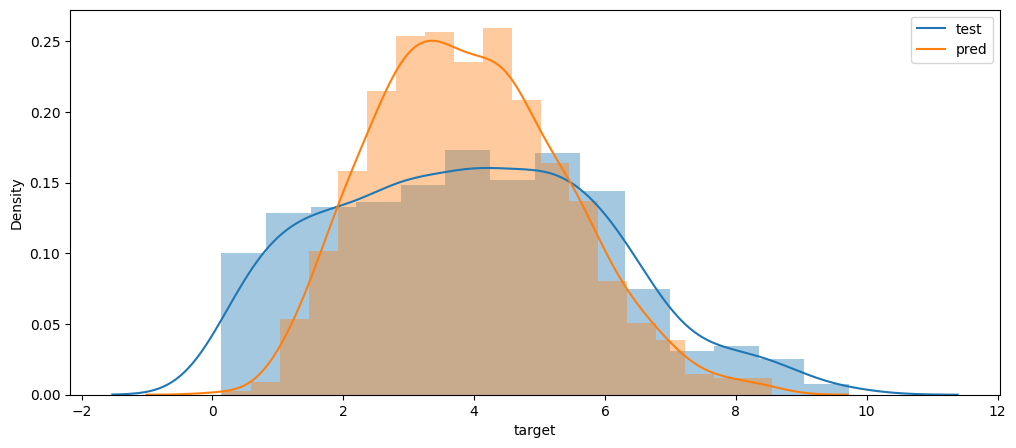

In [70]:
draw_target_distr(y_test, y_pred, save_fig=False, file_name='cat_distribution')

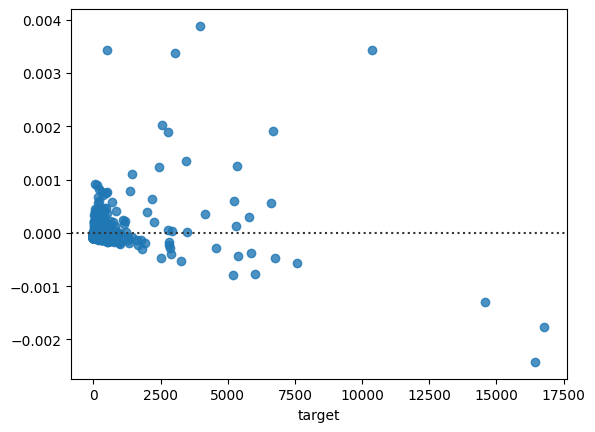

In [71]:
draw_residuals(y_test, y_pred, save_fig=False)

In [58]:
len(y_pred[y_pred <= 0])

0

## 2_2 keep release_year as cat

In [72]:
cat_features = ['type', 'subscription_only', 'actor_0', 'actor_1',
               'actor_2', 'actor_3', 'actor_4', 'country_0', 'genre_0', 'genre_1',
               'genre_2', 'director_0', 'SUBSCRIPTION', 'AVOD', 'DTO', 'RENT', 'release_year']

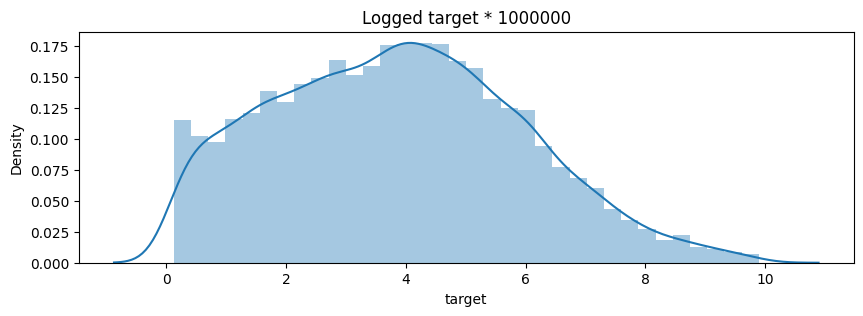

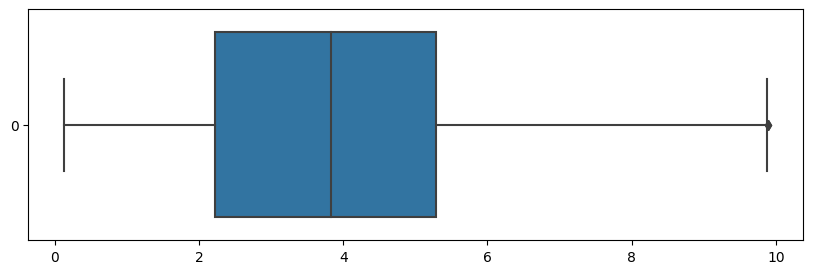

In [73]:
MULTIPLIER = 1000000
X, y = df_pr.drop(['target', 'name'], axis=1), df_pr['target'] * MULTIPLIER
y = target_transformer.transform(y)


plt.figure(figsize=(10, 3))
sns.distplot(y)
plt.title(f'Logged target * {MULTIPLIER}')
plt.show()

plt.figure(figsize=(10, 3))
sns.boxplot(y, orient='h')
plt.show()

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42, shuffle=True)
train_dataset = cat.Pool(X_train, y_train,
                         cat_features=cat_features,   
                        ) 
test_dataset = cat.Pool(X_test, y_test,
                         cat_features=cat_features,
                       )
val_dataset = cat.Pool(X_val, y_val,
                       cat_features=cat_features,
                      )

In [75]:
cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features,
    'iterations': 10000, 
}

cat_model = cat.CatBoostRegressor(**cat_params)

cat_model.fit(
    train_dataset,
    eval_set=val_dataset,
    early_stopping_rounds=50,
    verbose=100,
    plot=False
)

Learning rate set to 0.017502
0:	learn: 1.6958902	test: 1.6836634	best: 1.6836634 (0)	total: 12.1ms	remaining: 2m
100:	learn: 1.3636600	test: 1.3131019	best: 1.3131019 (100)	total: 1.09s	remaining: 1m 46s
200:	learn: 1.2735028	test: 1.2417492	best: 1.2417492 (200)	total: 2.24s	remaining: 1m 49s
300:	learn: 1.2344970	test: 1.2113855	best: 1.2113855 (300)	total: 3.35s	remaining: 1m 47s
400:	learn: 1.2084379	test: 1.1866347	best: 1.1866347 (400)	total: 4.47s	remaining: 1m 46s
500:	learn: 1.1890388	test: 1.1710397	best: 1.1710070 (497)	total: 5.57s	remaining: 1m 45s
600:	learn: 1.1704692	test: 1.1532603	best: 1.1532603 (600)	total: 6.63s	remaining: 1m 43s
700:	learn: 1.1553313	test: 1.1392211	best: 1.1391944 (699)	total: 7.68s	remaining: 1m 41s
800:	learn: 1.1423382	test: 1.1308656	best: 1.1308656 (800)	total: 8.77s	remaining: 1m 40s
900:	learn: 1.1315252	test: 1.1231855	best: 1.1231147 (899)	total: 9.87s	remaining: 1m 39s
1000:	learn: 1.1209793	test: 1.1163185	best: 1.1162975 (997)	total:

In [76]:
cat_model.save_model('2_2')

In [77]:
y_pred = cat_model.predict(X_test)

In [78]:
calc_metrics(y_test, y_pred, X)

*** VAL **: 
MSE:   1477341.4282414068
RMSE:  1215.4593486585254
R2:    0.22419558475547408
MAE:   313.0089569611943
MedAE: 36.440600597182
Adj_R2:  0.2225557529752067
------------------------------


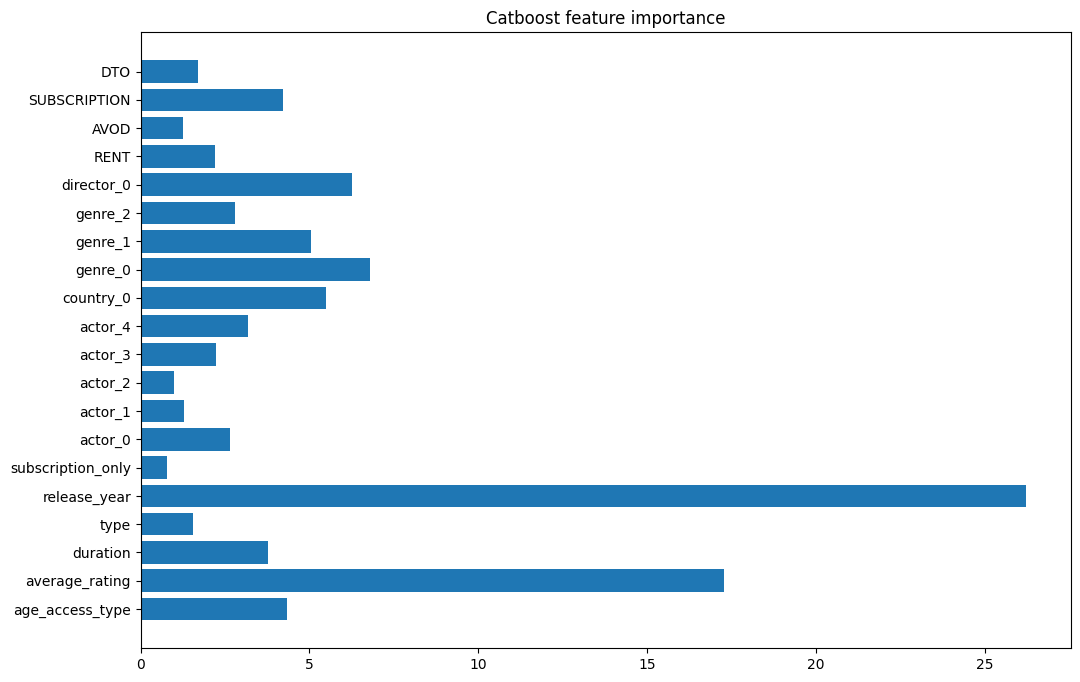

In [79]:
get_importance(train_dataset, cat_model, title='Catboost feature importance', save_fig=False, file_name='cat_feature_importance.png')

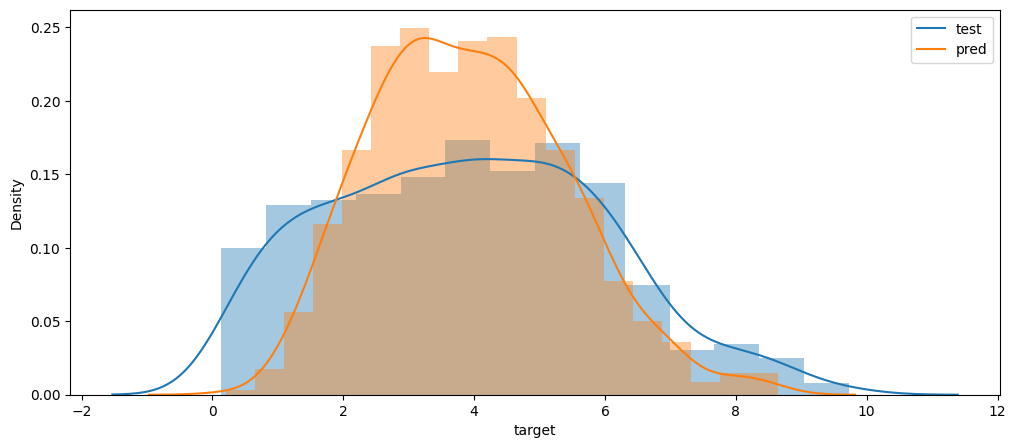

In [80]:
draw_target_distr(y_test, y_pred, save_fig=False, file_name='cat_distribution')

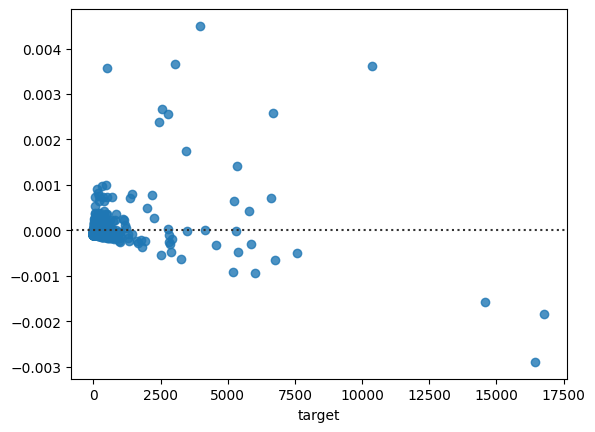

In [81]:
draw_residuals(y_test, y_pred, save_fig=False)

In [82]:
len(y_pred[y_pred <= 0])

0

## Tuning

In [1]:
cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features
}

train_dataset = cat.Pool(X_train, y_train,
                         cat_features=cat_features,
                         
                        ) 

NameError: name 'cat_features' is not defined

In [ ]:
parameters_distr = {'depth': randint(5, 10),
                    'learning_rate': uniform(0.01, 0.1),
                    'iterations': [5000, 10000, 15000],
                    'l2_leaf_reg':  uniform(0.01, 0.5)
                     }

cat_model = cat.CatBoostRegressor(**cat_params)
grid = RandomizedSearchCV(estimator=cat_model, param_distributions=parameters_distr, scoring='neg_mean_squared_error',
                          cv=3, n_jobs=-1, verbose=2)

grid.fit(X_train, y_train)

cat_model = grid.best_estimator_
cat_model.save_model('views_0_finetuned_cat')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, emb

0:	learn: 0.0405673	total: 116ms	remaining: 28m 59s
1:	learn: 0.0403087	total: 248ms	remaining: 31m 3s
2:	learn: 0.0400899	total: 362ms	remaining: 30m 10s
3:	learn: 0.0398467	total: 466ms	remaining: 29m 8s
4:	learn: 0.0396212	total: 784ms	remaining: 39m 11s
5:	learn: 0.0393485	total: 979ms	remaining: 40m 46s
6:	learn: 0.0391227	total: 1.36s	remaining: 48m 41s
7:	learn: 0.0389189	total: 1.57s	remaining: 49m 12s
8:	learn: 0.0386855	total: 1.74s	remaining: 48m 20s
9:	learn: 0.0384634	total: 2s	remaining: 50m 1s
10:	learn: 0.0382386	total: 2.31s	remaining: 52m 25s
11:	learn: 0.0380064	total: 2.78s	remaining: 57m 51s
12:	learn: 0.0378030	total: 3.11s	remaining: 59m 49s
13:	learn: 0.0376474	total: 3.98s	remaining: 1h 11m 5s
14:	learn: 0.0374766	total: 4.75s	remaining: 1h 19m 5s
15:	learn: 0.0372934	total: 5.18s	remaining: 1h 20m 52s
16:	learn: 0.0371565	total: 5.7s	remaining: 1h 23m 46s
17:	learn: 0.0369745	total: 6.22s	remaining: 1h 26m 19s
18:	learn: 0.0368520	total: 6.89s	remaining: 1h 30

In [336]:
cat_model = grid.best_estimator_

In [335]:
grid.best_params_

{'depth': 7,
 'iterations': 1000,
 'l2_leaf_reg': 0.4741523986764684,
 'learning_rate': 0.03353764113975911}

In [337]:
y_pred = cat_model.predict(X_test)

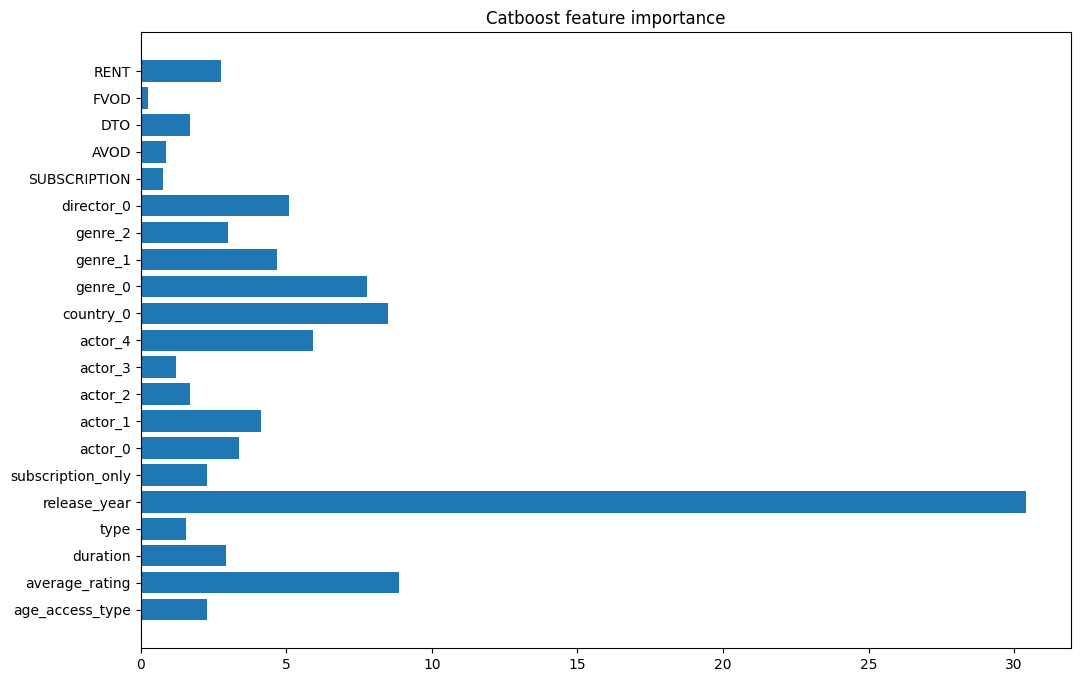

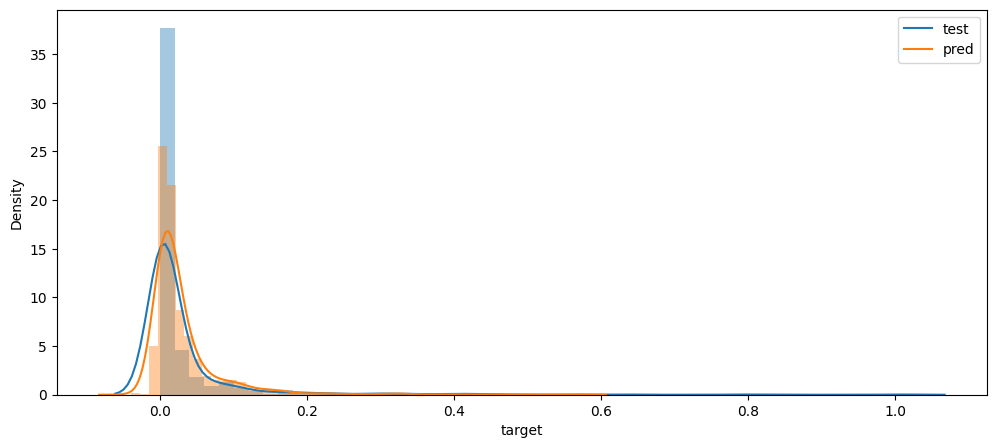

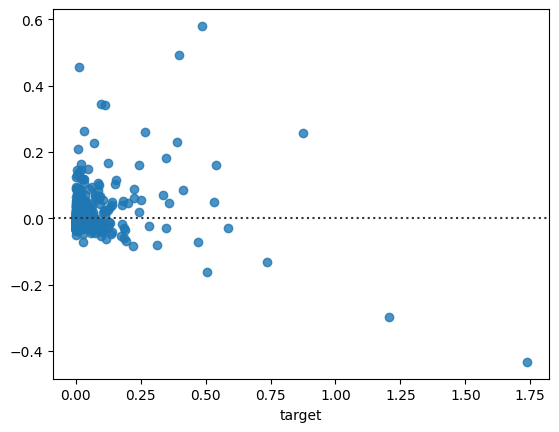

MAE 0.03239158378664328
R2 0.24055036453377243
Adj R2 0.23898295005271186


In [338]:
get_importance(train_dataset, cat_model, title='Catboost feature importance', save_fig=False, file_name='cat_feature_importance.png')
draw_target_distr(y_test, y_pred, save_fig=False, file_name='cat_distribution')
draw_residuals(y_test, y_pred, save_fig=False)
get_metrics(y_test, y_pred, X)

In [340]:
len(y_pred[y_pred <= 0])

99